# ДЗ 1

дедлайн - 26 ноября 23:59 либо неделя после но -5 баллов

**Общие указания**: за грязный и непонятный код без комментариев снижаются балы. Код должен быть структурирован (функции, классы). Если не получается описать код кратко в комментариях, то должны быть markdown ячейки с развернутым ответом.

**Оценивание**: каждое задание имеет одинаковый вес. Чтобы получить 10 нужно выполнить все дополнительные задания. Без выполнения дополнительных задания максимальная оценка - 6

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris, load_wine, load_breast_cancer
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

import warnings
warnings.filterwarnings('ignore')


# Задание 1

Процедура генерация датасета:
Сгенерируйте датасет с 10000 наблюдений и 1000 колонок (сэмплируйте из разных распеределений) и сформируйте из него таргет на основе 100 колонок + зашумление (общее или небольшое для каждой колонки - постарайтесь сделать так чтобы шум не сильно влиял на корреляции между предикторами и таргетам). Удостоверьтесь, что в датасете существуют колонки, которые не использовались для таргета, но при этом имеют высокую корреляцию с теми, что использовались (покажите это в коде).

Реализуйте forward stage wise регрессию стандартным образом и с помощью QR разложения наиболее быстрым образом (засекайте время для всех опробованных вариантов). Замерьте качество и процент колонок, которые были правильно найдены.

**Дополнительно**: 
Попробуйте генерировать данные таким образом, чтобы ошибка постепенно ухудшалась. Подсказка: увеличивайте шум, используйте нелинейные функции и комбинации предикторов. Попробуйте оценить bias и variance для forward stage-wise regression.

Создадим датасет и сделаем колонки, которые будут зависеть друг от друга, чтобы получить, чтобы были "колонки, которые не использовались для таргета, но при этом имеют высокую корреляцию с теми, что использовались"

Если все 1000 колонок просто случайно насэмплировать, то корреляция будет очень низкая, и мы не получим то, что требуется в условии задания

In [2]:
np.random.seed(0)

In [32]:
n_samples = 10000  # кол-во строк
n_features = 1000  # кол-во признаков
n_target = 100  # кол-во признаков, участвующих в расчете таргета

# ф-я для генерации данных с различными распределениями (стандартным нормальным, равномерным от 0 до 1, экспоненциальным)
def generate_random_data(n_samples, n_features):
    data = np.zeros((n_samples, n_features))
    for i in range(n_features):
        if i % 3 == 0:
            data[:, i] = np.random.normal(loc=0, scale=1, size=n_samples)
        elif i % 3 == 1:
            data[:, i] = np.random.uniform(low=0, high=1, size=n_samples)
        else:
            data[:, i] = np.random.exponential(scale=1, size=n_samples)

    return data

X = generate_random_data(n_samples, n_features)

# создаем признаки с высокой корреляцией
X[:, 0] = np.random.normal(0, 1, size=n_samples) 
X[:, 101] = X[:, 0] + np.random.normal(0, 0.1, size=n_samples)  
X[:, 102] = X[:, 1] + np.random.normal(0, 0.05, size=n_samples)  
X[:, 103] = X[:, 2] * 0.5 + X[:, 3] * 0.5 + np.random.normal(0, 0.05, size=n_samples)  

# делаем таргет: линейная комбинация первых 100 признаков + шум
coef = np.random.randn(n_target) # случайные коэф-ты для таргета
target = X[:, :n_target].dot(coef) + np.random.normal(0, 0.1, n_samples)


df = pd.DataFrame(X, columns=[f"feature_{i+1}" for i in range(n_features)])
df['target'] = target
df.head()


,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_992,feature_993,feature_994,feature_995,feature_996,feature_997,feature_998,feature_999,feature_1000,target
0,1.039662,0.093903,0.228364,-0.154808,0.979316,0.677495,0.557667,0.242177,0.025504,0.672020,...,0.514156,0.154641,-0.581748,0.440875,1.134187,-0.815313,0.662495,1.332901,-1.510766,-22.026692
1,1.273805,0.605219,2.524285,-0.129813,0.088687,1.176849,-0.549029,0.682880,1.016820,0.176216,...,0.377167,1.312120,-0.380964,0.805680,1.046853,-0.827680,0.339250,1.407267,1.230807,-22.328051
2,0.450417,0.453103,4.092929,0.272979,0.641036,0.275086,0.712191,0.189317,3.521247,0.443967,...,0.884287,5.174984,1.084871,0.368594,0.467916,-0.000514,0.374508,0.028471,0.094118,-2.342710
3,-2.216191,0.293557,0.333019,1.258650,0.592935,2.567962,-0.335899,0.831103,1.071187,0.327597,...,0.263612,0.945906,-1.251987,0.313926,0.154755,-1.228055,0.549720,1.042228,0.266613,2.283300
4,-0.330721,0.757238,1.602456,-0.944203,0.409360,0.132217,0.325730,0.362757,0.923574,-0.010752,...,0.281581,0.420525,-1.243151,0.900971,0.202255,-2.311840,0.566525,0.972872,-0.414326,-7.484884


In [33]:
# рассчитаем корреляцию между признаками между собой и признаками и таргетом
correlations = df.corr()
correlations


,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_992,feature_993,feature_994,feature_995,feature_996,feature_997,feature_998,feature_999,feature_1000,target
feature_1,1.000000,0.001794,0.001796,-0.010148,-0.009977,0.002457,0.005764,-0.007696,0.008922,0.003323,...,-0.009919,0.000080,-0.000224,-0.004573,-0.009110,-0.017922,0.002798,-0.012751,0.015148,-0.068873
feature_2,0.001794,1.000000,-0.007987,0.000426,-0.002443,-0.002268,-0.008032,-0.010411,0.008002,0.012253,...,0.000387,-0.008063,-0.012290,0.005822,0.007542,0.021571,0.010419,0.009111,-0.001221,-0.005523
feature_3,0.001796,-0.007987,1.000000,-0.000096,0.002150,0.010563,0.014981,0.001540,0.012172,-0.016294,...,-0.006401,0.001948,-0.011066,-0.008784,0.015635,-0.007180,-0.005491,-0.013604,-0.001077,-0.299671
feature_4,-0.010148,0.000426,-0.000096,1.000000,0.011514,-0.000036,-0.010050,0.009380,0.026704,-0.003226,...,-0.003550,-0.003653,-0.006491,-0.012844,-0.004582,-0.002876,0.006763,0.001576,0.005247,-0.229278
feature_5,-0.009977,-0.002443,0.002150,0.011514,1.000000,-0.008522,-0.002042,-0.000544,-0.008113,-0.000401,...,0.001912,-0.006669,-0.016659,-0.026911,0.013894,-0.004533,-0.017704,0.006437,-0.004058,0.000336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
feature_997,-0.017922,0.021571,-0.007180,-0.002876,-0.004533,-0.020122,0.006320,0.002399,-0.002446,-0.008537,...,-0.002800,0.012161,0.011575,0.003308,0.018260,1.000000,-0.002270,-0.007748,0.018318,-0.002203
feature_998,0.002798,0.010419,-0.005491,0.006763,-0.017704,0.009869,-0.012286,0.013201,0.009315,0.005930,...,0.000719,-0.008901,0.008688,-0.000426,-0.004828,-0.002270,1.000000,-0.003662,-0.022882,-0.013082
feature_999,-0.012751,0.009111,-0.013604,0.001576,0.006437,0.011440,0.002897,0.015882,0.005576,0.014843,...,0.000803,-0.002944,-0.011871,-0.026356,-0.006932,-0.007748,-0.003662,1.000000,0.013014,-0.000232
feature_1000,0.015148,-0.001221,-0.001077,0.005247,-0.004058,0.014909,-0.000685,-0.012893,0.018533,0.007496,...,-0.001848,-0.001445,0.008893,-0.007955,-0.006122,0.018318,-0.022882,0.013014,1.000000,0.002908


In [34]:
# удостоверимся, что в датасете существуют колонки, которые не использовались для таргета, 
# но при этом имеют высокую корреляцию (возьмем больше 0.65) с теми, что использовались
# при этом не смотрим на корреляцию признаков самих с собой (она = 1) и с таргетом
correlation_dict = {}

for feature1 in correlations.columns:
    for feature2 in correlations.columns:
        if feature1 != feature2 and feature1!='target' and feature2!='target' and abs(correlations.loc[feature1, feature2]) > 0.65:
            correlation_dict[(feature1, feature2)] = correlations.loc[feature1, feature2]

print("Словарь пар признаков с корреляцией > 0.65:")
print(correlation_dict)

Словарь пар признаков с корреляцией > 0.65:
{('feature_1', 'feature_102'): 0.9952113920076882, ('feature_2', 'feature_103'): 0.9850017148661468, ('feature_3', 'feature_104'): 0.711889359188453, ('feature_4', 'feature_104'): 0.6988112783802402, ('feature_102', 'feature_1'): 0.9952113920076882, ('feature_103', 'feature_2'): 0.9850017148661468, ('feature_104', 'feature_3'): 0.711889359188453, ('feature_104', 'feature_4'): 0.6988112783802402}


Реализуйте forward stage wise регрессию стандартным образом и с помощью QR разложения наиболее быстрым образом (засекайте время для всех опробованных вариантов). Замерьте качество и процент колонок, которые были правильно найдены.
- forward stagewise регрессия (стандартный способ):  на каждом шаге выбирается признак, который лучше всего улучшает качество предсказания
на основе текущего набора выбранных признаков (будем обновлять коэф-ты  пошагово, добавляя один признак за раз)

- с помощью qr разложения

In [35]:
X = df.drop(columns=['target'])  
Y = df['target']  

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

### Forward Stagewise регрессия

In [36]:
def forward_stagewise(X, Y, n_iter, eps, learning_limit):
    shape_x = X.shape[1]
    beta = np.zeros(shape_x)  # инициализация коэф-в
    R = Y.copy()
    X.columns = range(shape_x)  # переиндексация столбцов
    for _ in range(n_iter):
        correlations = X.T @ R
        j = np.argmax(correlations.abs()) # выбор признака с максимальной корреляцией
        if np.abs(correlations[j]) < learning_limit:
            break
        sign = np.sign(correlations[j])
        beta[j] += eps * sign
        R -= eps * sign * X.iloc[:, j]
    return beta


In [37]:
%%time
W = forward_stagewise(X_train, Y_train, n_iter=20000, eps=0.01, learning_limit=0.000001) # обучение Forward Stagewise
predictions = X_test @ W

mse = mean_squared_error(Y_test, predictions) 
print(f"MSE на тестовой выборке: {mse:.4f}")

MSE на тестовой выборке: 0.0289
CPU times: user 16min 14s, sys: 1min 33s, total: 17min 48s
Wall time: 3min 42s


посмотрим, сколько признаков было  выбраны (помним, что 100 участвовали в создании таргета)

In [9]:
selected_features = np.where(W != 0)[0]
print(f"Количество выбранных признаков: {len(selected_features)}")

Количество выбранных признаков: 94


In [10]:
# посчитаем количество правильных предсказаний (всё примерно поэтому:
# определим порог для абсолютной ошибки, например, 5% от среднего значения целевой переменной)
error_threshold = 0.05 * np.mean(Y_test) 

abs_errors = np.abs(predictions - Y_test)
correct_predictions = np.sum(abs_errors < error_threshold) # сколько предсказаний имеют ошибку меньше порога

percent_correct_predictions = (correct_predictions / len(Y_test)) * 100
print(f"Процент правильно предсказанных значений (ошибка < {error_threshold}): {percent_correct_predictions:.4f}%")

Процент правильно предсказанных значений (ошибка < 0.22414890915844482): 81.4500%


In [11]:

def forward_stagewise_qr(X, Y, n_iter, eps, learning_limit):
    shape_x = X.shape[1]
    beta = np.zeros(shape_x)  
    Res = Y.copy()
    X.columns = range(shape_x)  
    Q, R = np.linalg.qr(X.values)  # QR-разложение матрицы X

    for _ in range(n_iter):
        # Обновление остатков
        correlations = Q.T @ Res  # вместо X.T @ Res, используем Q.T
        j = np.argmax(np.abs(correlations))  
        
        if np.abs(correlations[j]) < learning_limit:
            break

        sign = np.sign(correlations[j])
        beta[j] += eps * sign
        Res -= eps * sign * Q[:, j]  # используем Q[:, j]

    return beta


In [12]:
%%time
W_qr = forward_stagewise_qr(X_train, Y_train, n_iter=1000, eps=0.01, learning_limit=0.000001) # обучение Forward Stagewise
predictions_qr = X_test @ W_qr

mse = mean_squared_error(Y_test, predictions_qr) 
print(f"MSE на тестовой выборке: {mse:.4f}")

MSE на тестовой выборке: 162.8888
CPU times: user 1min, sys: 4.93 s, total: 1min 5s
Wall time: 16.2 s


# Задание 2

Можно использовать EM алгоритм для создания mixture of experts для классических моделей машинного обучения. Прочитайте об этом в секции 11.2.4 и 11.4.3 в книге Machine Learning- A Probabilistic Perspective (найти можно например тут: https://vk.com/doc-44016343_199213512?hash=2ad697dae93b3fea0e). Реализуйте mixture of experts для линейной регрессии. 

Создайте несколько датасетов с переменными и трагетом, имеющими похожее ораспределение но с разной зависимость от переменных (не забудьте про шум!), объедините их и постройте mixture of experts для этой модели, посчитайте качество и сравните его с обычной линейной регрессией. 

**Дополнительно**: постепенно делайте дастасеты все более и более похожими и смотрите, как это влияет на bias, variance и разницу с обычной линейной регрессией (разница должны становится меньше). 

In [13]:
class MixtureOfExperts:
    def __init__(self, n_experts):
        self.n_experts = n_experts
        self.gmm = None
        self.experts = []
        self.weights = None
    
    def fit(self, X_train, y_train):
        self.gmm = GaussianMixture(n_components=self.n_experts, random_state=0)
        self.gmm.fit(X_train)
        self.weights = self.gmm.predict_proba(X_train)  # вероятности принадлежности каждого примера к экспертам
        
        # эксперты (линейная регрессия) на взвешенных данных
        self.experts = []
        for i in range(self.n_experts):
            X_weighted = X_train * self.weights[:, i].reshape(-1, 1)  
            y_weighted = y_train.reshape(-1) * self.weights[:, i]  
            #  лин регрессия для текущего эксперта
            expert = LinearRegression()
            expert.fit(X_weighted, y_weighted)
            self.experts.append(expert)
    
    def predict(self, X):
        y_pred = np.sum(self.weights * np.array([expert.predict(X) for expert in self.experts]).T, axis=1)
        return y_pred

In [14]:
# данныe для нескольких экспертов с 3 коэффициентами
def generate_expert_data(n_experts=3, samples_per_expert=100, n_features=3):
    X_i = []
    y_i = []
    for i in range(n_experts):
        coeff = np.random.randint(-3, 4, size=n_features)
        X = np.random.normal(loc=10*i, scale=i*2, size=(samples_per_expert, n_features))  
        y = X @ coeff 
        y += np.random.normal(0, 0.1*i , X.shape[0])
        y = y.reshape(-1,1)
        X_i.append(X)
        y_i.append(y)
    
    X = np.vstack(X_i)
    y = np.vstack(y_i)
    return X, y


def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    return mean_squared_error(y, y_pred)

In [15]:
X_all, y_all = generate_expert_data()
X_train, y_train = X_all, y_all

# Mixture of Experts 
moe_model = MixtureOfExperts(n_experts=3)
moe_model.fit(X_train, y_train)
mse_moe = evaluate_model(moe_model, X_train, y_train)
print(f'MSE для Mixture of Experts: {mse_moe:.4f}')

# обычная лин регрессия
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
mse_lr = evaluate_model(linear_model, X_train, y_train)
print(f'MSE для обычной линейной регрессии: {mse_lr:.4f}')


MSE для Mixture of Experts: 0.4960
MSE для обычной линейной регрессии: 23.5764


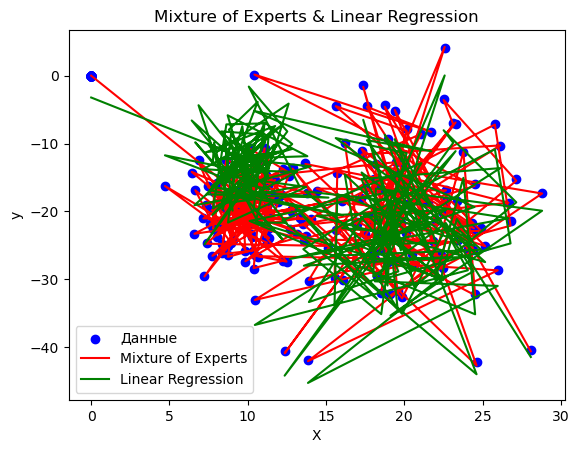

In [16]:
plt.scatter(X_train[:, 0], y_train, color='blue', label='Данные')
plt.plot(X_train[:, 0], moe_model.predict(X_train), color='red', label='Mixture of Experts')
plt.plot(X_train[:, 0], linear_model.predict(X_train), color='green', label='Linear Regression')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.title('Mixture of Experts & Linear Regression')
plt.show()

# Задание 3

Реализуйте регулеризованый LDA с двумя параметрами из лекции. Сравните его с логистической рергерссией (осуществите тюнинг гиперпараметров для обоих моделей) на публичных датасетах (хотя бы 5) из UCI (https://archive.ics.uci.edu/).

**Дополнительно**: постарайтесь найти датасеты, где LDA работает лучше и попробуйте объяснить почему.

Подсказка: если данных достаточно много, то LDA и LogReg не будут отличаться даже если предположения LDA выполняются - попробуйте уменьшать обучающую выборку чтобы найти ситуации, когда LDA работает лучше. Если не получается с публичными датасетами - сгенерируйте (в этом случае посчитайте bias и variance для LDA и LorReg).

In [17]:
import numpy as np

class RegularizedLDA:
    def __init__(self):
        self.class_covariances = None
        self.class_covariances_inv = None
        self.discriminant_constants = None
        self.class_means = None
        self.class_probabilities = None
        self.num_classes = None

    def fit(self, X, y, alpha=0.5, gamma=0.1):
        classes = np.unique(y)
        n_samples, n_features = X.shape
        class_counts = {cl: np.sum(y == cl) for cl in classes}
        n_classes = np.array(list(class_counts.values()))

        # вероятности классов (π_k) 
        self.class_probabilities = n_classes / n_samples

        self.num_classes = len(classes)
        self.class_means = np.array([X[y == cl].mean(axis=0) for cl in classes]) # средние значения для каждого класса
        global_covariance = np.cov(X, rowvar=False)   # общауя ковариационная матрица
        global_covariance = gamma * global_covariance + (1 - gamma) * np.std(X, axis=0)[:, None] * np.eye(n_features)  # регуляризация ков-й матрицы

        # ковариации внутри классов с регуляризацией
        self.class_covariances = []
        self.class_covariances_inv = []
        for cl in classes:
            class_cov = np.cov(X[y == cl], rowvar=False)
            regularized_cov = alpha * class_cov + (1 - alpha) * global_covariance
            self.class_covariances.append(regularized_cov)
            self.class_covariances_inv.append(np.linalg.inv(regularized_cov))

       
        self.discriminant_constants = [
            (-0.5 * np.log(np.linalg.det(self.class_covariances[i])) + np.log(self.class_probabilities[i]))
            for i in range(self.num_classes)
        ]  # конст дискриминантных функций (для каждого класса)

    def predict(self, X):
        discriminants = np.zeros((X.shape[0], self.num_classes))
        for i in range(self.num_classes):
            diff = X - self.class_means[i]  # разность между объектом и средним для каждого класса
            #  дискриминантная функция для каждого класса
            discriminants[:, i] = np.sum(diff @ self.class_covariances_inv[i] * diff, axis=1)
            discriminants[:, i] = -0.5 * discriminants[:, i] + self.discriminant_constants[i]

        return np.argmax(discriminants, axis=1)

    def accuracy(self, X_test, y_test):
        y_pred = self.predict(X_test)
        return np.mean(y_pred == y_test)


In [18]:
def load_scale():
    df = pd.read_csv("https://archive.ics.uci.edu/static/public/12/data.csv")
    dataset = {}
    dataset['data'] = df.drop(columns='class')  
    dataset['target'] = df['class']  
    label_encoder = LabelEncoder()
    dataset['target'] = label_encoder.fit_transform(dataset['target'])

    return dataset

def load_seeds():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt"
    df = pd.read_csv(url, sep="\\t+", header=None)
    
    return df



In [19]:
# список датасетов UCI 
datasets = {
    'iris': load_iris(),
    'wine': load_wine(),
    'breast_cancer': load_breast_cancer(),
    'seeds': load_seeds(),
    "balance_scale": load_scale(),

}


def compare_rda_logreg():
    results = []

    # итерация по всем датасетам
    for dataset_name, dataset in datasets.items():
        if isinstance(dataset, dict):
            X = dataset['data']
            y = dataset['target']
        else:
            X = dataset.iloc[:, :-1].values
            y = dataset.iloc[:, -1].values - 1
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

        scaler = StandardScaler()  # стандартизируем данные
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        
        param_grid_rda = {
            'alpha': [0.1, 0.5, 1.0],
            'gamma': [0.01, 0.1, 0.5, 1.0]
        }
        best_rda_sc = 0
        best_rda_params = None
        
        # попробуем разные значения гиперпараметров alpha и gamma
        for alpha in param_grid_rda['alpha']:
            for gamma in param_grid_rda['gamma']:
                rda_model = RegularizedLDA()
                rda_model.fit(X_train_scaled, y_train, alpha=alpha, gamma=gamma)
                rda_sc = rda_model.accuracy(X_test_scaled, y_test)
                
                if rda_sc > best_rda_sc:
                    best_rda_sc = rda_sc
                    best_rda_params = {'alpha': alpha, 'gamma': gamma}

        
        param_grid_lr = {'C': [0.01, 0.1, 1, 10, 100]} #подбираем параметры для log reg
        lr_model = LogisticRegression(max_iter=10000)
        grid_search_lr = GridSearchCV(lr_model, param_grid_lr, cv=5, n_jobs=-1)
        grid_search_lr.fit(X_train_scaled, y_train)
        lr_best_model = grid_search_lr.best_estimator_
        lr_score = lr_best_model.score(X_test_scaled, y_test)


        results.append({
            'Dataset': dataset_name,
            'Best LDA Accuracy': best_rda_sc,
            'Best LDA Alpha': best_rda_params['alpha'],
            'Best LDA Gamma': best_rda_params['gamma'],
            'Best Logistic Regression Accuracy': lr_score,
            'Best Logistic Regression C': grid_search_lr.best_params_['C']
        })

    df_res = pd.DataFrame(results)
    return df_res

results_df = compare_rda_logreg()
results_df


,Dataset,Best LDA Accuracy,Best LDA Alpha,Best LDA Gamma,Best Logistic Regression Accuracy,Best Logistic Regression C
0,iris,0.933333,1.0,0.01,0.933333,10.0
1,wine,1.000000,1.0,0.01,1.000000,0.1
2,breast_cancer,0.964912,0.5,0.01,0.973684,1.0
3,seeds,0.952381,0.1,0.01,0.952381,10.0
4,balance_scale,0.912000,1.0,0.01,0.912000,100.0


# Задание 4

Реализуйте LDA + GMM на размеченных и неразмеченных данных с помошью EM алгоритма. Для этого для датасетов из предыдущего задания для некоторых наблюдений выкиньте информацию о таргетах из обучающей выборки. Посмотрите, работает ли такой подход лучше, чем если бы мы полностью выкинули неразмеченные данные.

**Дополнительно**: посмотрите, как меняется качество, когда доля неразмеченных данных падает.

датасет iris - точность на тестовой выборке: 0.36666666666666664


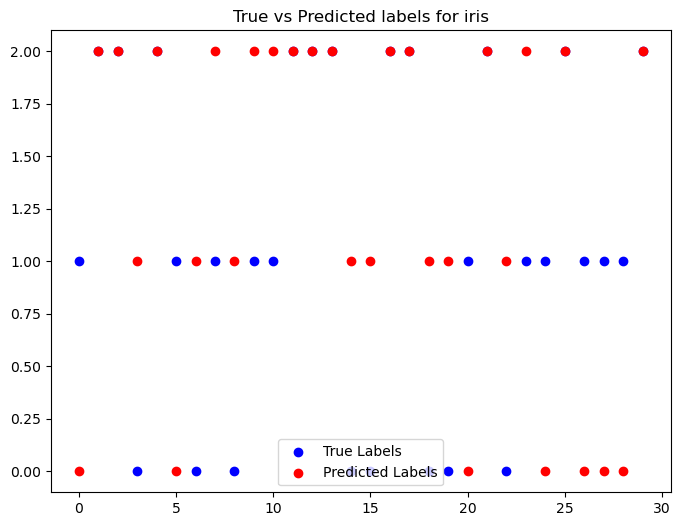

In [30]:
def apply_LDA_GMM(dataset_name, dataset):
    X = dataset['data']
    y = dataset['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

    mask = np.random.rand(len(y_train)) < 0.3  # удалим 30% меток
    y_train[mask] = -1  
    lda = LDA()
    X_train_lda = lda.fit_transform(X_train, y_train)
    gmm = GaussianMixture(n_components=len(np.unique(y)), random_state=5)
    gmm.fit(X_train_lda)

    y_pred = gmm.predict(lda.transform(X_test))
    print(f"датасет {dataset_name} - точность на тестовой выборке:", accuracy_score(y_test, y_pred))
    return y_test, y_pred

dataset_name = 'iris'  
y_test, y_pred = apply_LDA_GMM(dataset_name, datasets[dataset_name])

plt.figure(figsize=(8, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='True Labels', alpha=1.0)
plt.scatter(range(len(y_pred)), y_pred, color='red', label='Predicted Labels', alpha=1.0)
plt.legend()
plt.title(f"True vs Predicted labels for {dataset_name}")
plt.show()


датасет wine - точность на тестовой выборке: 0.3055555555555556


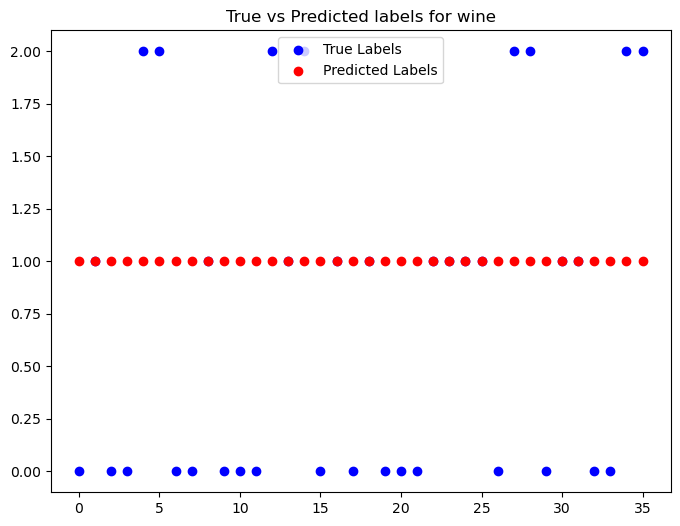

In [31]:
dataset_name = 'wine'  
y_test, y_pred = apply_LDA_GMM(dataset_name, datasets[dataset_name])

plt.figure(figsize=(8, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='True Labels', alpha=1.0)
plt.scatter(range(len(y_pred)), y_pred, color='red', label='Predicted Labels', alpha=1.0)
plt.legend()
plt.title(f"True vs Predicted labels for {dataset_name}")
plt.show()


In [51]:
# попытка реализовать с ем алгоритом

def lda_gmm_with_em(X_labeled, y_labeled, X_unlabeled, n_iter=100):
    lda = LDA()
    lda.fit(X_labeled, y_labeled)
    y_unlabeled_prob = lda.predict_proba(X_unlabeled) # вероятности классов для неразмеченных данных
    y_unlabeled = np.argmax(y_unlabeled_prob, axis=1)  # класс с максимальной вероятностью

    for _ in range(n_iter):
        X = np.vstack([X_labeled, X_unlabeled])
        y = np.concatenate([y_labeled, y_unlabeled])
        lda.fit(X, y)
        y_unlabeled_prob = lda.predict_proba(X_unlabeled)
        y_unlabeled = np.argmax(y_unlabeled_prob, axis=1)

    return lda
